In [1]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
import json
import numpy as np
import regex as re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%run config.ipynb # this line runs the config.ipynb file, which stores my API key

# import researchpy as rp
# import scipy.stats as stats  # these 2 not needed currently

In [2]:
# Setting display options for printing pandas dfs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 40)

In [3]:
#api_key

## Creating functions to use later

In [4]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )
    response = request.execute()
    
    for item in response["items"]: # the key 'items' in the response JSON dict gives a list of items, each one about a specified YT channel.
        data = {
            "channel_name" : item["snippet"]["title"],
            "playlistId" : item["contentDetails"]["relatedPlaylists"]["uploads"]
        }
        
        all_data.append(data)
    return pd.DataFrame(all_data)

In [5]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [6]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

## Running functions

In [7]:
api_service_name = 'youtube'
api_version = 'v3'
# note that api_key given below is pulled from the config.ipynb file

youtube = build(
    api_service_name, api_version, developerKey=api_key)

channel_ids = [ 'UCa90xqK2odw1KV5wHU9WRhg', 'UCX6OQ3DkcsbYNE6H8uQQuVA', 'UCzQUP1qoWDoEbmsQxvdjxgQ']
# these ^ are the channel IDs of The Office, PowerfulJRE and MrBeast. I found them by 'inspecting source'  

channel_stats_df = get_channel_stats(youtube, channel_ids)

In [8]:
channel_stats_df.head()

,channel_name,playlistId
0,The Office,UUa90xqK2odw1KV5wHU9WRhg
1,MrBeast,UUX6OQ3DkcsbYNE6H8uQQuVA
2,PowerfulJRE,UUzQUP1qoWDoEbmsQxvdjxgQ


#### Putting all video details into one df:

In [9]:
df_list = []
playlist_ids = channel_stats_df["playlistId"].values

for playlist_id in playlist_ids:
    video_ids = get_video_ids(youtube, playlist_id)
    video_details_df = get_video_details(youtube, video_ids)
    df_list.append(video_details_df)
    
all_channels_df = pd.concat(df_list)

In [10]:
all_channels_df["channelTitle"].value_counts()

channelTitle
The Office     1142
PowerfulJRE    1058
MrBeast         743
Name: count, dtype: int64

In [11]:
mr_beast_df = all_channels_df[all_channels_df["channelTitle"] == "MrBeast"]
jre_df = all_channels_df[all_channels_df["channelTitle"] == "PowerfulJRE"]
the_office_df = all_channels_df[all_channels_df["channelTitle"] == "TheOffice"]

## Mr Beast Dollar Analysis

In [12]:
# Amending data types of columns
mr_beast_df[["viewCount","likeCount", 'commentCount']] = mr_beast_df[["viewCount","likeCount", 'commentCount']].apply(pd.to_numeric)
mr_beast_df["publishedAt"] = pd.to_datetime(mr_beast_df["publishedAt"], format='%Y-%m-%dT%H:%M:%SZ')

# Adding a new column which is a Boolean denoting whether the title has "$" in it or not
mr_beast_df["title_has_$"] = mr_beast_df["title"].str.contains("\$")

C:\Users\lukeb\AppData\Local\Temp\ipykernel_21468\3468020607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mr_beast_df[["viewCount","likeCount", 'commentCount']] = mr_beast_df[["viewCount","likeCount", 'commentCount']].apply(pd.to_numeric)
C:\Users\lukeb\AppData\Local\Temp\ipykernel_21468\3468020607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mr_beast_df["publishedAt"] = pd.to_datetime(mr_beast_df["publishedAt"], format='%Y-%m-%dT%H:%M:%SZ')
C:\Users\lukeb\AppData\Local\Temp\ipykernel_21468\34

In [13]:
# Here we reduce the dataset for this analysis down to just the videos after Mr Beast posted his first one with a dollar sign 
# in it. This is because there's a lot of less-watched vids he made early on that were of a different genre to his later videos
# It makes sense to start the analysis from when he began posting videos similar rto what he currently produces.

first_dollar_vid = mr_beast_df[mr_beast_df["title_has_$"] == True].sort_values(by='publishedAt').iloc[0]["publishedAt"]

print(first_dollar_vid)

mr_beast_dollars_df = mr_beast_df.copy()
mr_beast_dollars_df = mr_beast_dollars_df[mr_beast_dollars_df["publishedAt"] > first_dollar_vid]

2015-03-05 02:07:01


In [14]:
dollars_df = mr_beast_dollars_df[mr_beast_dollars_df["title_has_$"] == True]
no_dollars_df = mr_beast_dollars_df[mr_beast_dollars_df["title_has_$"] == False]

# ^ in case we want to look at the df's separately

In [15]:
# Getting some stats from the dollars_df and no_dollars_df

print("Number of dollars vids: " + str(len(dollars_df)))
print("Number of No dollars vids: " + str(len(no_dollars_df)))

print("Dollars average: " + str(dollars_df["viewCount"].mean().round(1)))
print("No Dollars average: " + str(no_dollars_df["viewCount"].mean().round(1)))#

print("Dollars max: " + str(dollars_df['viewCount'].max()))
print("No Dollars max: " + str(no_dollars_df['viewCount'].max()))

Number of dollars vids: 115
Number of No dollars vids: 457
Dollars average: 96031720.1
No Dollars average: 41263215.5
Dollars max: 478391658
No Dollars max: 875390801


In [23]:
# More in depth stats
pd.set_option('display.float_format', lambda x: '%.1f' % x)

print("DOLLARS:")
print(dollars_df["viewCount"].describe().apply("{0:.2f}".format))
print("\nNO DOLLARS:")
print(no_dollars_df["viewCount"].describe().apply("{0:.2f}".format))

DOLLARS:
count          115.00
mean      95304856.04
std       87101401.87
min          36131.00
25%       23879778.50
50%       70106238.00
75%      142708620.50
max      474200813.00
Name: viewCount, dtype: object

NO DOLLARS:
count          456.00
mean      40791535.86
std       81530832.07
min          35298.00
25%          61359.00
50%         614885.00
75%       44359278.25
max      868105999.00
Name: viewCount, dtype: object


In [32]:
def create_plot(df_dict):
    
    for df_name in df_dict:
        df = df_dict[df_name]
        df_new = df.copy()
        df_new["colour"] = df["title_has_$"].map({True:"green", False:"red"}) # this line was added in hope that the plots would be made on same graph, but no dic - ATM
        ax = df_new.plot(x="publishedAt", y="viewCount", color=df_new["colour"].values, style=".", legend=None)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
        plt.ylabel("View count (millions)")
        plt.xlabel("Video publish date")
        title = "Video view counts - '$' NOT in video title" if "no" in df_name else "Video view counts - '$' in video title" 
        plt.title(title)
        plt.show()


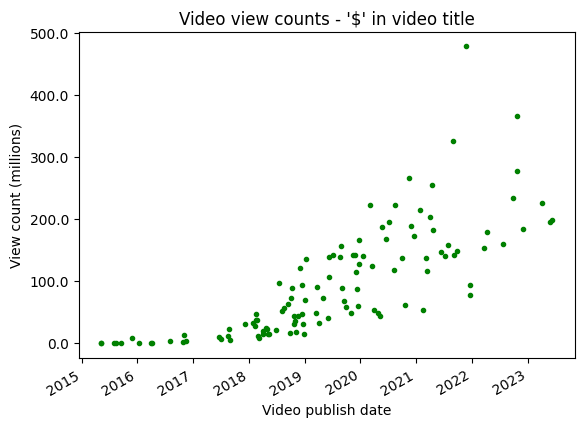

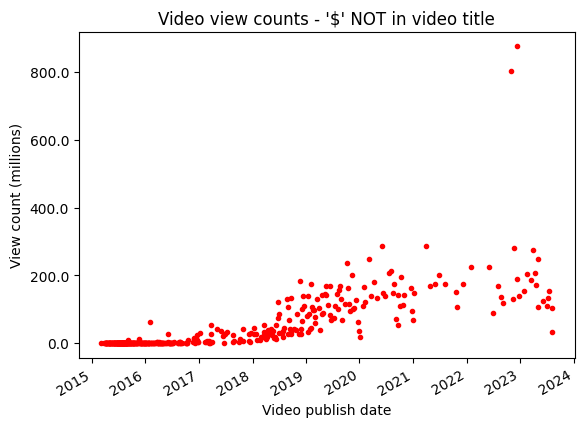

In [33]:
df_dict = {
    "dollars_df": dollars_df,
    "no_dollars_df": no_dollars_df
    }

create_plot(df_dict)

In [41]:
hue_plot_df = mr_beast_dollars_df[["viewCount", 'publishedAt', 'title_has_$']]
hue_plot_df.loc[hue_plot_df['title_has_$']==True, 'title_has_$'] = "$ in title"
hue_plot_df.loc[hue_plot_df['title_has_$']==False, 'title_has_$'] = "$ NOT in title"

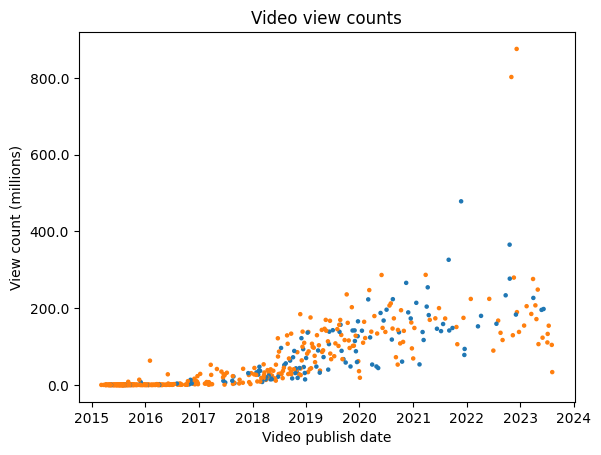

In [42]:
# ax = hue_plot_df.plot.scatter(x="publishedAt", y="viewCount", style=".", legend=None, hue='title_has_$')

colours = {'$ in title':'tab:blue', '$ NOT in title':'tab:orange'}


ax = hue_plot_df.plot.scatter(x="publishedAt", y="viewCount", style=".", legend=None, s=5, c=hue_plot_df['title_has_$'].map(colours))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
plt.ylabel("View count (millions)")
plt.xlabel("Video publish date")
title = "Video view counts"
plt.title(title)
plt.show()


After looking at the stats and the plots of the sets of videos uploaded by Mr Beast that either have or do not have the "$" symbol in the title, I can see that ones with a dollar sign have a higher view count. The average number of views for videos with dollars is more than double those without (94 million compared to 40 million). The median is also 10x higher whioch is a huge disproprtion. The maximum nubmer of views is far higher as well, however this video along with one other (both around 800 million views mark) are outliers when compared with view counts for other "dollar" videos, as can be seen in the time series plots.

A potential reason for the difference in view counts here is that the videos with the dollar symbol in the title of Mr Beast's videos usually have a monetary prize that contestants can win (i.e. "Offering People $100,000 To Quit Their Job"). The viewers of his videos take more interest in videos of these types than ones that do not have a prize as a focual point of the video.

Based on this, if Mr Beast was primarily concerned on maximising the number of views of the videos, I would suggest uploading more videos with the "$" in the title. However this could mean he needs to offer the people participating in his videos large amounts of moeny which he may not be keen to do, so I'll leave that decison up to him!

### JRE - Relationship between likes, views, comments

In [27]:
all_channels_df[['viewCount', 'likeCount', 'commentCount']] = all_channels_df[['viewCount', 'likeCount', 'commentCount']].apply(pd.to_numeric)
all_channels_df["likes_to_views"] = (all_channels_df["likeCount"] / all_channels_df["viewCount"]) *100


mr_beast_df = all_channels_df[all_channels_df["channelTitle"] == "MrBeast"]
jre_df = all_channels_df[all_channels_df["channelTitle"] == "PowerfulJRE"]
the_office_df = all_channels_df[all_channels_df["channelTitle"] == "The Office"]

In [28]:
jre_df[["likes_to_views",'viewCount', 'likeCount', 'commentCount']].head()

,likes_to_views,viewCount,likeCount,commentCount
0,NaN,0,0.0,0.0
1,1.9,911579,17092.0,4784.0
2,2.1,442734,9473.0,865.0
3,3.0,2648497,80605.0,11833.0
4,2.2,159500,3563.0,368.0


In [29]:
# mr_beast_df = mr_beast_df.sort_values("viewCount", ascending=False)
# jre_df = jre_df.sort_values("viewCount", ascending=False)
# the_office_df = the_office_df.sort_values("viewCount", ascending=False)

In [30]:
#Removing this row as it causes issue where its puts in top row when sorting likes to views as it has 0 views

jre_df = jre_df[jre_df["title"] != "JRE Fight Companion - February 11, 2023"]


In [31]:
jre_df_likes_to_views = jre_df.sort_values("likes_to_views", ascending=False).head(10)
jre_df_views = jre_df.sort_values("viewCount", ascending=False).head(10)
jre_df_likes = jre_df.sort_values("likeCount", ascending=False).head(10)
jre_df_comments = jre_df.sort_values("commentCount", ascending=False).head(10)

[Text(0.5, 0, 'Comment count (thousands)'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Top 10 commented JRE videos')]

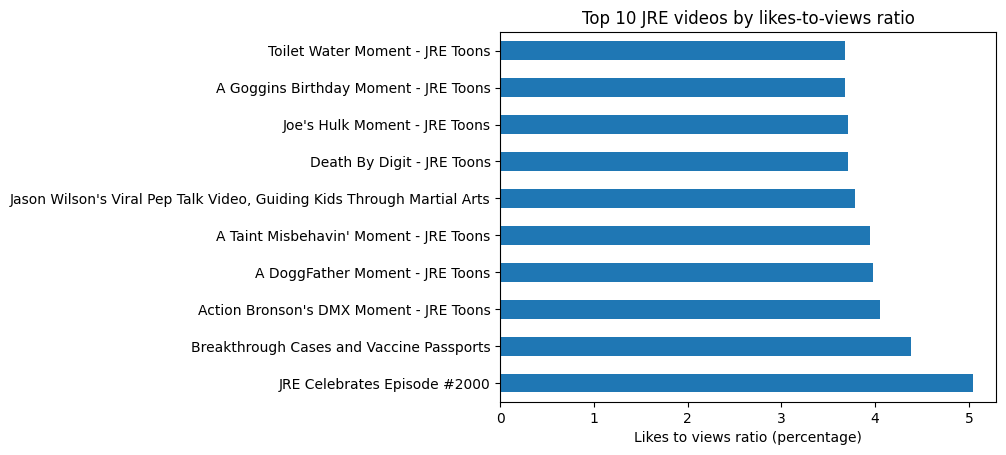

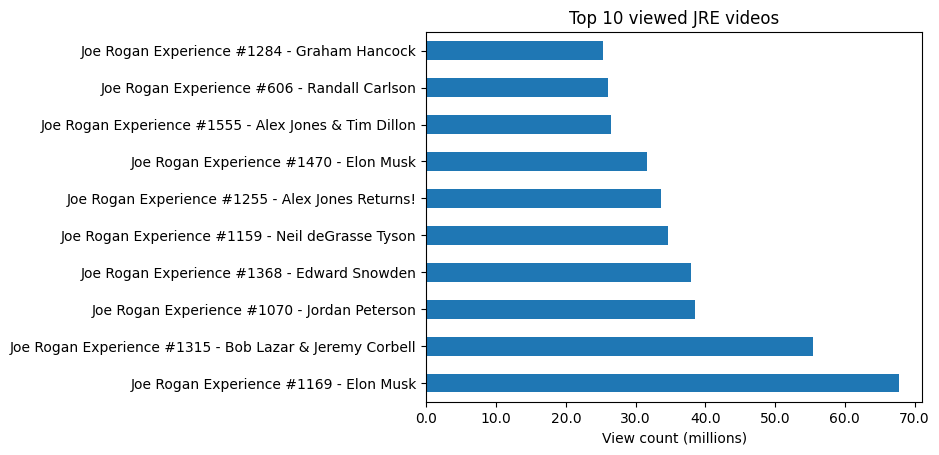

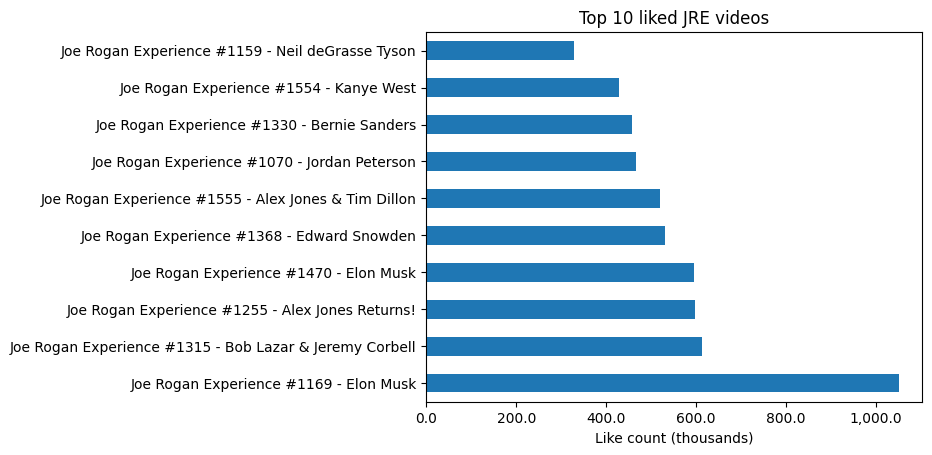

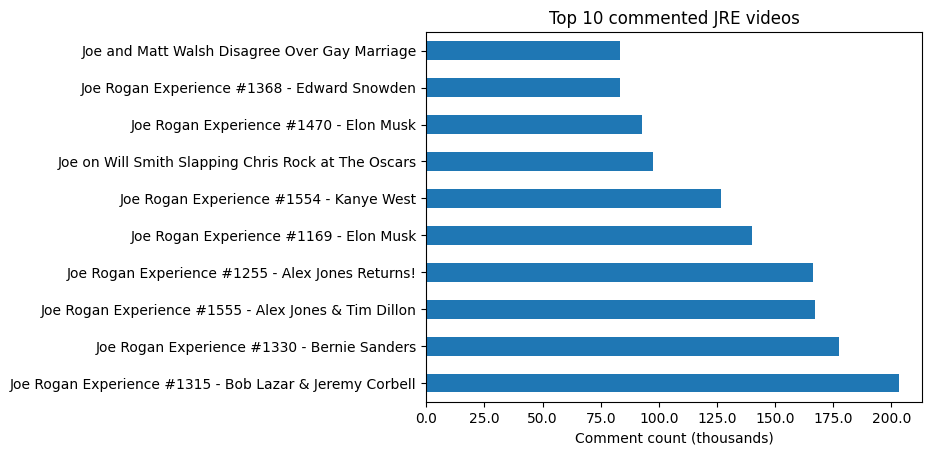

In [32]:
# Plotting the comment likes-to-views ratio of top 10 JRE vids
ax = jre_df_likes_to_views.plot.barh(x="title", y="likes_to_views", legend=None)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set(xlabel="Likes to views ratio (percentage)", ylabel=None, title="Top 10 JRE videos by likes-to-views ratio")


# def add_value_label(x_list,y_list):
#     for i in range(1, len(x_list)+1):
#         plt.text(i,y_list[i-1],y_list[i-1])

# add_value_label(jre_df_likes_to_views["title"].values, jre_df_likes_to_views["likes_to_views"])

# Plotting the view count of top 10 JRE vids
ax = jre_df_views.plot.barh(x="title", y="viewCount", legend=None)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
ax.set(xlabel="View count (millions)", ylabel=None, title="Top 10 viewed JRE videos")

# Plotting the like count of top 10 JRE vids
ax = jre_df_likes.plot.barh(x="title", y="likeCount", legend=None)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000, ',')))
ax.set(xlabel="Like count (thousands)", ylabel=None, title="Top 10 liked JRE videos")

# Plotting the comment count of top 10 JRE vids
ax = jre_df_comments.plot.barh(x="title", y="commentCount", legend=None)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000, ',')))
ax.set(xlabel="Comment count (thousands)", ylabel=None, title="Top 10 commented JRE videos")

In [35]:
jre_df[jre_df["title"].isin(["Joe Rogan Experience #1169 - Elon Musk", "Joe Rogan Experience #1315 - Bob Lazar & Jeremy Corbell"])]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,likes_to_views
948,BEWz4SXfyCQ,PowerfulJRE,Joe Rogan Experience #1315 - Bob Laz...,Bob Lazar is a physicist who worked ...,"[Joe Rogan Experience, JRE, Joe, Rog...",2019-06-21T03:00:00Z,55446078,612461.0,None,203158.0,PT2H14M45S,hd,false,1.1
978,ycPr5-27vSI,PowerfulJRE,Joe Rogan Experience #1169 - Elon Musk,"Elon Musk is a business magnet, inve...","[Joe Rogan Experience, Joe Rogan, JR...",2018-09-07T08:12:43Z,67734150,1051263.0,None,139913.0,PT2H37M3S,hd,false,1.6


In [36]:
1 - (610515.0/1050883.0)

0.41904569776083544

#### Note - I did my analysis of the the above data investigation in the Google Docs sheet!

## Analysis on The Office videos

Want to look at the relation between length of videos and how many views the get and their like like-to-view ratio

In [38]:
the_office_df = all_channels_df[all_channels_df["channelTitle"] == "The Office"]

In [39]:
# See below markdown for explanation on what I'm doing in this cell.

print(len(the_office_df))

mask_longer_than_hour = the_office_df["duration"].str.contains("H")
# print(mask_longer_than_hour)

the_office_df = the_office_df[~mask_longer_than_hour] # note the tilda here!

print(len(the_office_df))

1136
1135


^This shows us how many videos are more than an hour long. Note you should print the head of 
the_office_df["duration"] col to see the format of duration. Its a bit weird, with H, M and S
used to denote hours, mins and secs.

From the above code we can see there's only 1 vid with duration more than an hour. This vid is in
fact 10hrs long. We remove this video from our analysis as it is a huge outlier compared to 
other videos and this would distort our plots later on (all the shorter vids would be bunched 
together in order to display the vid that is 10hrs long.)

In [42]:
def get_minutes(wd):
    try:
        if "T" not in wd:
            return 0

        elif "S" not in wd:
            return int(wd[2:].split("M")[0])

        elif "M" not in wd:
            secs = int(wd[2:].split("S")[0])
            mins = round(secs/60,2)
            return mins

        else:
            nums = re.search('PT(.+?)M(.+?)S', wd)
            if nums:
                mins = int(nums.group(1))
                secs = int(nums.group(2))
            return mins + round(secs/60, 2)
    except:
        print("ISSUE WITH THIS VALUE!")

In [43]:
print(get_minutes("PT12M59S"))

12.98


In [46]:
the_office_df["duration_time"] = the_office_df["duration"].apply(lambda x: get_minutes(x))

In [49]:
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(the_office_df[["duration", "duration_time"]].head())
    
# NOTE: I printed it like this because the precsion was note close enough in duration_time col
# without it and I wanted the vals to be more precise.

# Here's what I want to plot:
print("\n")
print(the_office_df[["title", "duration_time", "viewCount"]].head())

   duration  duration_time
0  PT15M35S          15.58
1     PT50S           0.83
2  PT13M11S          13.18
3     PT39S           0.65
4    PT5M2S           5.03


                                     title  duration_time  viewCount
0  Fans Said These Characters Would Be ...           15.6      89505
1  Was this the funniest foreshadowing ...            0.8     435012
2  Office PRANKS to Watch While You Eat...           13.2     248533
3  Did you notice John Krasinski breaki...            0.7    1027118
4  Dwight Becomes A Private Investigato...            5.0      81912


Text(0, 0.5, 'View count (millions)')

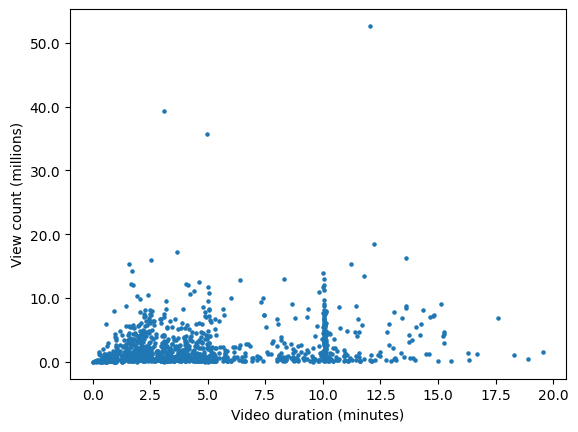

In [50]:
# ax = the_office_df.plot.scatter(x="duration_time", y="viewCount")

# This^ gives an unclear plot as most of the data points are very bunced up. Will remove vids that
# are >20mins long.

the_office_df = the_office_df[the_office_df["duration_time"] < 20]

ax = the_office_df.plot.scatter(x="duration_time", y="viewCount", s=5)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
ax.set_xlabel("Video duration (minutes)")
ax.set_ylabel("View count (millions)")

In [51]:
print(the_office_df["duration_time"].corr(the_office_df["viewCount"]))
print(round(the_office_df['duration_time'].mean(), 3))

0.1838875320185356
4.863


In [60]:
print(the_office_df.loc[(the_office_df["viewCount"] < 40000000) & (the_office_df["viewCount"] >37000000)])

         video_id channelTitle                           title  \
1104  Vmb1tqYqyII   The Office  First Aid Fail - The Office US   

                                  description  \
1104  Michael Scott is performing first ai...   

                                         tags           publishedAt  \
1104  [dummy, first aid, bee gees, the bee...  2015-05-08T16:01:39Z   

      viewCount  likeCount favouriteCount  commentCount duration definition  \
1104   39300053   608546.0           None       15444.0   PT3M7S         hd   

     caption  likes_to_views  duration_time  
1104    true             1.5            3.1  


From the scatter plot, it doesn't immediately seem like there is much of a relationship between the video duration and view count. 
The correlation between these 2 variables was calculated to be 0.188 which indicates a slight positive correlation. However, it's not strong enough to suggest increasing the length of videos. The video with the second hifghest nubmer of views at 39.3million was only 3 minutes long.

Text(0, 0.5, 'Likes to views ratio (%))')

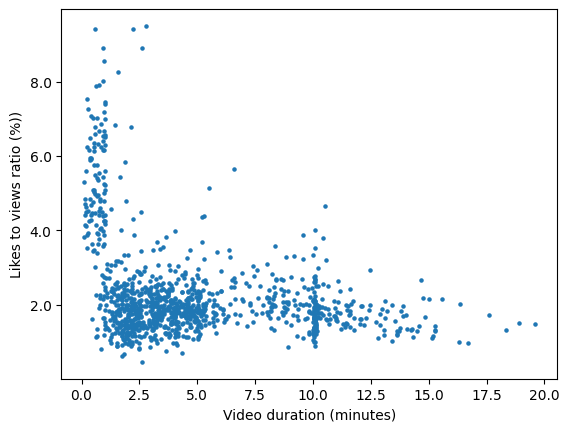

In [73]:
ax = the_office_df.plot.scatter(x="duration_time", y="likes_to_views", s=5)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/1, ',')))
ax.set_xlabel("Video duration (minutes)")
ax.set_ylabel("Likes to views ratio (%))")

In [64]:
print(the_office_df[["duration_time", "likes_to_views"]].corr())

                duration_time  likes_to_views
duration_time             1.0            -0.3
likes_to_views           -0.3             1.0


The above plot illustratres the relationship between video duration and the like-to-view ratio. It can be seen that there is some negative correlation between these 2 variables (calculated to be -0.3). Many of the most liked videos are under 1 minute. This can likely be explained by many of these videos being YouTube Shorts which attract a lot of likes. 

In [70]:
the_office_df["likes_to_views"].head()

0   2.1
1   6.9
2   1.8
3   5.4
4   2.4
Name: likes_to_views, dtype: float64

In [74]:
print(all_channels_df.columns)

Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'duration', 'definition', 'caption', 'likes_to_views'],
      dtype='object')
